The target values must be in a column of the dataframe, and must be a numerical datatype, so we must convert them before training.

IMPORTANT: Notice that we are importing `ImageDataGenerator` from `keras_preprocessing` instead of `keras.preprocessing`, because the people at Keras are a bunch of old reactionary dinosaurs.

See the discussion [here](https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1), and [here](https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1).

In [1]:
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load data and preparation

The csv files `db.csv` contains all the metadata we have extracted from wikiart: every entry corresponds to an artwork, and the `_id` column contains the filename of the image in the `data/images/` directory associated to that artwork.

In [2]:
feature = "style"

In [3]:
nrows = None # to load all 
df = pd.read_csv("../data/db.csv",nrows=nrows,na_values="?")

Let's look at this dataframe:

In [4]:
df.dropna(subset=[feature,],inplace=True)
df[feature] = df[feature].map(lambda s: str(s).split(",")[0].strip())

In [5]:
df.head()

,_id,artistname,genre,image,image_size_data,style,title,year
0,57727b22edc2cb3880e0d820,giovanni battista piranesi,design,https://uploads1.wikiart.org/images/giovanni-b...,"[{'sizekb': 13, 'width': 210, 'height': 266, '...",neoclassicism,"plan, elevation and details of doric temples i...",NaN
1,57727b22edc2cb3880e0d830,giovanni battista piranesi,design,https://uploads0.wikiart.org/images/giovanni-b...,"[{'sizekb': 8, 'width': 210, 'height': 149, 'u...",neoclassicism,plans of elevations and sections of thermopolium,NaN
2,57727b22edc2cb3880e0d840,giovanni battista piranesi,design,https://uploads3.wikiart.org/images/giovanni-b...,"[{'sizekb': 7, 'width': 210, 'height': 148, 'u...",neoclassicism,plants related to the houses opposite to that ...,NaN
3,57727b22edc2cb3880e0d850,giovanni battista piranesi,sketch and study,https://uploads2.wikiart.org/images/giovanni-b...,"[{'sizekb': 6, 'width': 210, 'height': 161, 'u...",neoclassicism,pluto,NaN
4,57727b23edc2cb3880e0d860,giovanni battista piranesi,sketch and study,https://uploads8.wikiart.org/images/giovanni-b...,"[{'sizekb': 10, 'width': 210, 'height': 296, '...",neoclassicism,pluto and proserpina,NaN


Let's initialize a dataimage generator: it is a nice interface towards many (pre)processing method in Keras, including some utilities for data augmentation.

We will use the amazing `flow_from_dataframe` function to serve the data we need.

If the files do not have an extension, run this in a shell:

    $ for f in *; do mv "$f" "$f.jpg"; done

In [41]:
df["genre"]

0                     design
1                     design
2                     design
3           sketch and study
4           sketch and study
5                     veduta
6                   interior
7                   portrait
8                   portrait
9                   portrait
10            genre painting
11                    design
12                    design
13                    design
14          sketch and study
15                 cityscape
16                    design
17                 cityscape
18                    design
19                    design
20                  interior
21          sketch and study
22            genre painting
23                 cityscape
24          sketch and study
25        religious painting
26                 capriccio
27                    design
28                    design
29            genre painting
                 ...        
151984                marina
151985             landscape
151986                marina
151987        

In [6]:
df.describe()

,_id,artistname,genre,image,image_size_data,style,title,year
count,148475,148475,147296,148475,148475,148475,148472,116120
unique,148475,2763,355,148475,148475,167,112816,2672
top,57726f58edc2cb3880ba7563,vincent van gogh,portrait,https://uploads4.wikiart.org/images/paul-cezan...,"[{'sizekb': 4, 'width': 210, 'height': 163, 'u...",impressionism,untitled,1910
freq,1,1927,21291,1,1,14978,4349,1277


In [7]:
df["style"].value_counts().describe()

count      167.000000
mean       889.071856
std       2220.387477
min          1.000000
25%         44.500000
50%        176.000000
75%        471.000000
max      14978.000000
Name: style, dtype: float64

## Classes

Decide here what feature we want to predict, and save in the `classes` set all the possible values: they are the values that appear at least once in the database.

Some of the labels are composite: there are subclasses. During the training for simplicity we dropped the lower level specifications and just kept the top level tags. For example "cubism,precisionism" will be simply classified as "cubism".

Let's load the dictionary containing the classes we used during training:

In [8]:
with open('../data/classes.pkl', 'rb') as f:
    class_indices = pickle.load(f)

It's also useful to have a map from class number to class names

In [9]:
ind_class = {v: k for k, v in class_indices.items()}

A few examples of the kind of classes we will predict:

In [10]:
classes = list(class_indices.keys())
classes[:10]

['sketch and study',
 'miniature',
 'installation',
 'performance',
 'literary painting',
 'advertisement',
 'cloudscape',
 'mythological painting',
 'vanitas',
 'design']

## Image Size

The images will be scaled down to this size

In [11]:
img_size = (256,256)

## Create data generators

In [12]:
datagen = ImageDataGenerator(rescale=1/255)

In [13]:
test_generator = datagen.flow_from_dataframe(
                                df,
                                directory="../data/images/",
                                x_col="_id",
                                has_ext=False,
                                target_size=img_size,
                                y_col=feature,
                                batch_size=1) 
# ,
#                                 classes = classes)

Found 148475 images belonging to 167 classes.


In [14]:
test_ind_class = {v: k for k, v in test_generator.class_indices.items()}

# Load Model 

In [15]:
model = load_model('../data/model.h5')

/home/ksrnk/opt/anaconda3/envs/science/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# Evaluate

This returns the loss and accuracy

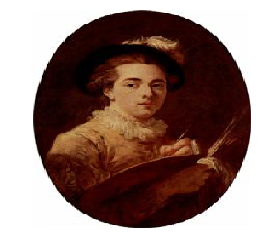

In [35]:
test_img = test_generator.next()

plt.imshow(test_img[0][0]);plt.axis('off');

The true label is

In [36]:
test_ind_class[np.argmax(test_img[1])]

'rococo'

In [37]:
pred = model.predict(test_img[0])[0]

In [38]:
top5 = np.argsort(pred)[:-6:-1]

In [39]:
pred[top5]

array([9.3123192e-01, 5.7745483e-02, 6.8284478e-03, 1.8787278e-03,
       9.0220693e-04], dtype=float32)

Let's print the top five predictions for this image

In [40]:
for p in top5:
    print(ind_class[p])

portrait
self-portrait
religious painting
literary painting
genre painting
